# Legal Opinion Classification with XLNET

This notebook runs Judgements Classification Task using xlnet-base-cased Model.

### Requirements: 
*   Notebook required authentication with the google drive account containing datasets. 

*   Make sure that Datasets are available in the drive authenticated.

*   Paths can be modified in cell <a href='#scrollTo=RMTSD1_Ree5Z'>[this cell]</a> for Dataset to direct the notebook to pickup the required resources correctly. 

*   Datasets can be requested (if not accessible) from Cells in its respective section in this notebook.

This notebook was prepared on Google Colaboratory, and run on Google Compute Engine Backend (GPU).

In [1]:
#Final one
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#install transformers library from huggingface.
!pip install -qq transformers

     |████████████████████████████████| 1.3MB 8.7MB/s 
     |████████████████████████████████| 890kB 29.1MB/s 
     |████████████████████████████████| 1.1MB 43.3MB/s 
     |████████████████████████████████| 2.9MB 53.4MB/s 


In [3]:
#@title Imports, Setup & Config

import os
import math
from tqdm import tqdm,trange

import numpy as np
import pandas as pd
from collections import defaultdict
from textwrap import wrap


import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


import transformers
from transformers import (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

# Introduction

In this notebook, we run judgement classification on the legal dataset

- Load and preprocess data
- Parse data
- Make training data
- Train model
- Evaluate result

## Load data

**Mount Drive and Copy Judgement Data**

Need access to this dataset? Request via [email](mailto:khan06@ads.uni-passau.de?subject=Requesting%20Access%20to%20Judgement%20Set&body=I%20need%20access%20to%20following%20Dataset%3A%0D%0Ahttps%3A%2F%2Fdrive.google.com%2Ffile%2Fd%2F1_ZoKro8G43PLqLN_fK_JXff1USz-pr4b%2Fview%3Fusp%3Dsharing%0D%0A)

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
INPUT_DATASET = "judgements_dataset.zip"
#copy judgements data from drive
!cp /gdrive/My\ Drive/Master\ Thesis/Master_Thesis-Comparing_the_Performance_of_NLP_Toolkits_and_Evaluation_measures_in_Legal_tech/Datasets/classification_datasets/20k_judgements.zip $INPUT_DATASET
#extract the judgements data
!unzip $INPUT_DATASET

Archive:  judgements_dataset.zip
  inflating: judgement_type_dissent.tsv  
  inflating: judgement_type_majority.tsv  


**Load CSV data**

In [6]:
dissent_opinions = "judgement_type_dissent.tsv"
majority_opinions = "judgement_type_majority.tsv"
class_names = ['dissent', 'majority']

In [7]:
#method for reading the judgements from input files passsed in arguments
def getData(files):
  data = {}
  data["id"] = []
  data["sentence"] = []
  data["label"] = []
  judgement_data = pd.DataFrame.from_dict(data) # initialize an empty dataframe
  
  for file in files:
    df = pd.read_csv(file, '\t')
    judgement_data = pd.concat([judgement_data, df]).reset_index(drop=True)
  judgement_data['id'] = judgement_data['id'].astype(int).astype(str)
  judgement_data = judgement_data.sample(frac=1.0).reset_index(drop=True)
  return judgement_data

#read the opinions data into a dataframe
judgements_data = getData([majority_opinions, dissent_opinions])

#shuffle the data to mix up the majority and dissent judgements
df_data=judgements_data.sample(frac=1.0).reset_index(drop=True)

df_data.head()


id                                           sentence     label
0   985  Before his trial, Defendant filed a motion for...  majority
1   997  The Court of Appeals held that NMSA , A A , wh...  majority
2  7871  The majority chose to analyze an endorsement t...   dissent
3   688  That evidence, coupled with the evidence that ...  majority
4  7506  Contemnors are correct when they argue that be...   dissent

In [8]:
# Have a look labels
df_data.label.unique()

array(['majority', 'dissent'], dtype=object)

In [9]:
# Analyse the labels distribution
df_data.label.value_counts()

dissent     9995
majority    9932
Name: label, dtype: int64

## Parse data

**Parse data into document structure**

In [10]:
# Get judegments text
sentences = df_data.sentence.to_list()

In [11]:
# Get judgements labels
labels = df_data.label.to_list()

**Change TAG name into index for training**

In [12]:
# Set a dict for mapping id to tag name
# Recommended to set it by manual define, good for reusing
# 0:majority, 1: dissent
tag2idx={'majority': 0,
 'dissent': 1}

In [13]:
# Mapping index to name (reversing the dict)
tag2name={tag2idx[key] : key for key in tag2idx.keys()}

In [14]:
tag2name

{0: 'majority', 1: 'dissent'}

## Make tranning data

Make trainable data from raw data, for XLNet.

**Set up gpu environment**

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [16]:
n_gpu

1

### Load tokenizer

Remember to install sentencepiece with  'pip install sentencepiece'

In [17]:
# Manual define vocabulary address, if you download the model in local
# The vocabulary can download from "https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-spiece.model"
vocabulary = 'xlnet-base-cased-spiece.model'

In [18]:
!wget https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-spiece.model

--2020-11-13 09:24:11--  https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-spiece.model
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.20.27
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.20.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 798011 (779K) [binary/octet-stream]
Saving to: ‘xlnet-base-cased-spiece.model’

xlnet-base-cased-sp 100%[===================>] 779.31K  2.34MB/s    in 0.3s    

2020-11-13 09:24:11 (2.34 MB/s) - ‘xlnet-base-cased-spiece.model’ saved [798011/798011]



In [19]:
# With cased model, set do_lower_case = False
tokenizer = XLNetTokenizer(vocab_file=vocabulary,do_lower_case=False)

### Set text input embedding

- token id embedding
- mask embedding
- segment embedding

In [20]:
max_len  = 256

full_input_ids = []
full_input_masks = []
full_segment_ids = []

SEG_ID_A   = 0
SEG_ID_B   = 1
SEG_ID_CLS = 2
SEG_ID_SEP = 3
SEG_ID_PAD = 4

UNK_ID = tokenizer.encode("<unk>")[0]
CLS_ID = tokenizer.encode("<cls>")[0]
SEP_ID = tokenizer.encode("<sep>")[0]
MASK_ID = tokenizer.encode("<mask>")[0]
EOD_ID = tokenizer.encode("<eod>")[0]

for i,sentence in enumerate(sentences):
    # Tokenize sentence to token id list
    tokens_a = tokenizer.encode(sentence)
    
    # Trim the len of text
    if(len(tokens_a)>max_len-2):
        tokens_a = tokens_a[:max_len-2]
        
        
    tokens = []
    segment_ids = []
    
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(SEG_ID_A)
        
    # Add <sep> token 
    tokens.append(SEP_ID)
    segment_ids.append(SEG_ID_A)
    
    
    # Add <cls> token
    tokens.append(CLS_ID)
    segment_ids.append(SEG_ID_CLS)
    
    input_ids = tokens
    
    # The mask has 0 for real tokens and 1 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [0] * len(input_ids)

    # Zero-pad up to the sequence length at fornt
    if len(input_ids) < max_len:
        delta_len = max_len - len(input_ids)
        input_ids = [0] * delta_len + input_ids
        input_mask = [1] * delta_len + input_mask
        segment_ids = [SEG_ID_PAD] * delta_len + segment_ids

    assert len(input_ids) == max_len
    assert len(input_mask) == max_len
    assert len(segment_ids) == max_len
    
    full_input_ids.append(input_ids)
    full_input_masks.append(input_mask)
    full_segment_ids.append(segment_ids)
    
    if 3 > i:
        print("No.:%d"%(i))
        print("sentence: %s"%(sentence))
        print("input_ids:%s"%(input_ids))
        print("attention_masks:%s"%(input_mask))
        print("segment_ids:%s"%(segment_ids))
        print("\n")
    
    
    
    

No.:0
sentence: Before his trial, Defendant filed a motion for judgment of acquittal asserting that because Nava was found not guilty, the doctrine of collateral estoppel prevented the State from proceeding against Defendant.. The State appeals the judgment of not guilty on the ground the doctrine of collateral estoppel cannot be invoked to dismiss the charges against Defendant.. d , Ct.App. holding double jeopardy did not attach where court ruled before trial that the State could not prove the defendant acted unlawfully as a matter of law and was therefore not guilty Kott v.. , L.Ed. d , the Supreme Court of the United States addressed the question whether the contemporary doctrine of nonmutual collateral estoppel, unknown at common law until , could be applied to bar the government from relitigating the guilt of the principal in a subsequent trial against an accessory.
input_ids:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Set label embedding

In [21]:
# replace categorical labels with numerical values.
tags = [tag2idx[str(lab)] for lab in labels]
print(tags[0])

0


## Split data into train and validate

70% for training, 15% for validation, 15% for testing

**Split all data**

In [22]:
tr_inputs, val_inputs, tr_tags, val_tags,tr_masks, val_masks,tr_segs, val_segs = train_test_split(full_input_ids, tags,full_input_masks,full_segment_ids, 
                                                            random_state=4, test_size=0.3)

In [23]:
valid_inputs, test_inputs, valid_tags, test_tags,valid_masks, test_masks,valid_segs, test_segs = train_test_split(val_inputs, val_tags,val_masks,val_segs, 
                                                            random_state=4, test_size=0.5)

In [24]:
len(tr_inputs),len(valid_inputs),len(test_inputs),len(tr_segs),len(valid_segs),len(test_segs)

(13948, 2989, 2990, 13948, 2989, 2990)

**Set data into tensor**

Not recommend tensor.to(device) at this process, since it will run out of GPU memory

In [25]:
tr_inputs = torch.tensor(tr_inputs)
valid_inputs = torch.tensor(valid_inputs)
test_inputs = torch.tensor(test_inputs)
tr_tags = torch.tensor(tr_tags)
valid_tags = torch.tensor(valid_tags)
test_tags = torch.tensor(test_tags)
tr_masks = torch.tensor(tr_masks)
valid_masks = torch.tensor(valid_masks)
test_masks = torch.tensor(test_masks)
tr_segs = torch.tensor(tr_segs)
valid_segs = torch.tensor(valid_segs)
test_segs = torch.tensor(test_segs)

**Put data into data loader**

In [26]:
# Set batch num
batch_num = 16

# Set token embedding, attention embedding, segment embedding
train_data = TensorDataset(tr_inputs, tr_masks,tr_segs, tr_tags)
train_sampler = RandomSampler(train_data)
# Drop last can make batch training better for the last one
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_num,drop_last=True)

valid_data = TensorDataset(valid_inputs, valid_masks,valid_segs, valid_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_num)

test_data = TensorDataset(test_inputs, test_masks,test_segs, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_num)

## Train model

**Load XLNet model**

In [27]:
!mkdir xlnet

In [28]:
!cp xlnet-base-cased-spiece.model xlnet/

In [29]:
!wget https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json

--2020-11-13 09:24:27--  https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.102.85
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.102.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [application/json]
Saving to: ‘xlnet-base-cased-config.json’

xlnet-base-cased-co 100%[===================>]     760  --.-KB/s    in 0s      

2020-11-13 09:24:27 (12.7 MB/s) - ‘xlnet-base-cased-config.json’ saved [760/760]



In [30]:
!mv xlnet-base-cased-config.json xlnet/config.json

In [31]:
# In this document, contain confg(txt) and weight(bin) files
model_file_address = 'xlnet-base-cased'

In [32]:
# Download model from "https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-pytorch_model.bin"
# Download model from "https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json" 
model = XLNetForSequenceClassification.from_pretrained(model_file_address,num_labels=len(tag2idx))

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [33]:
model;

In [34]:
# Set model to GPU,if you are using GPU machine
model.to(device);

In [35]:
# Add multi GPU support
if n_gpu >1:
    model = torch.nn.DataParallel(model)

In [36]:
# Set epoch and grad max num
epochs = 10
max_grad_norm = 1.0

In [37]:
# Cacluate train optimiazaion num
num_train_optimization_steps = int( math.ceil(len(tr_inputs) / batch_num) / 1) * epochs

### Set fine tuning method

**Manual optimizer**

In [38]:
# True: fine tuning all the layers 
# False: only fine tuning the classifier layers
# Since XLNet in 'pytorch_transformer' did not contian classifier layers
# FULL_FINETUNING = True need to set True
FULL_FINETUNING = True

In [39]:
if FULL_FINETUNING:
    # Fine tune model all layer parameters
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    # Only fine tune classifier parameters
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

### Fine-tuing model

In [40]:
# TRAIN loop
model.train();

In [41]:
#method to save a trained model

def save_model(model, xlnet_out_address, model_version):
  model_path = os.path.join(xlnet_out_address, model_version)
  if not os.path.exists(model_path):
    os.makedirs(model_path)
  
  # Save a trained model, configuration and tokenizer
  model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
  output_model_file = os.path.join(model_path, "pytorch_model.bin")
  output_config_file = os.path.join(model_path, "config.json")
  
  # Save model into file
  torch.save(model_to_save.state_dict(), output_model_file)
  model_to_save.config.to_json_file(output_config_file)
  tokenizer.save_vocabulary(model_path)


In [42]:
print("***** Running training *****")
print("  Num examples = %d"%(len(tr_inputs)))
print("  Batch size = %d"%(batch_num))
print("  Num steps = %d"%(num_train_optimization_steps))
for _ in trange(epochs,desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_segs,b_labels = batch
        
        # forward pass
        outputs = model(input_ids =b_input_ids,token_type_ids=b_segs, input_mask = b_input_mask,labels=b_labels)
        loss, logits = outputs[:2]
        if n_gpu>1:
            # When multi gpu, average it
            loss = loss.mean()
        
        # backward pass
        loss.backward()
        
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        
        # update parameters
        optimizer.step()
        optimizer.zero_grad()

    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    save_model(model, "xlnet_ft_trained", str(_))
    

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 13948
  Batch size = 16
  Num steps = 8720
Train loss: 0.26493122441112466


Epoch:  10%|█         | 1/10 [18:16<2:44:24, 1096.10s/it]

Train loss: 0.17298832461403643


Epoch:  20%|██        | 2/10 [36:32<2:26:10, 1096.28s/it]

Train loss: 0.12115179572472815


Epoch:  30%|███       | 3/10 [54:49<2:07:54, 1096.37s/it]

Train loss: 0.09185814613745848


Epoch:  40%|████      | 4/10 [1:13:05<1:49:38, 1096.37s/it]

Train loss: 0.0660283741467261


Epoch:  50%|█████     | 5/10 [1:31:21<1:31:21, 1096.28s/it]

Train loss: 0.0494945447514503


Epoch:  60%|██████    | 6/10 [1:49:37<1:13:04, 1096.16s/it]

Train loss: 0.04560621070895618


Epoch:  70%|███████   | 7/10 [2:07:53<54:48, 1096.04s/it]  

Train loss: 0.03567853672570844


Epoch:  80%|████████  | 8/10 [2:26:08<36:31, 1095.73s/it]

Train loss: 0.029750159971285547


Epoch:  90%|█████████ | 9/10 [2:44:24<18:15, 1095.93s/it]

Train loss: 0.024771129024174377


Epoch: 100%|██████████| 10/10 [3:02:40<00:00, 1096.09s/it]


In [43]:
# Def acc funtion
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

# Evaluate on Validation Data
def evaluate_validation_data(model_version):
  xlnet_out_address = os.path.join('xlnet_ft_trained', model_version)
  model = XLNetForSequenceClassification.from_pretrained(xlnet_out_address,num_labels=len(tag2idx))
  model.to(device);
  if n_gpu >1:
    model = torch.nn.DataParallel(model)
  
  # Evalue loop
  model.eval();

  #run evaluation on Validation Data
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  y_true = []
  y_predict = []
  for step, batch in enumerate(valid_dataloader):
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_segs,b_labels = batch
      
      with torch.no_grad():
          outputs = model(input_ids =b_input_ids,token_type_ids=b_segs, input_mask = b_input_mask,labels=b_labels)
          tmp_eval_loss, logits = outputs[:2]
      
      # Get textclassification predict result
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      tmp_eval_accuracy = accuracy(logits, label_ids)

      # Save predict and real label reuslt for analyze
      for predict in np.argmax(logits, axis=1):
          y_predict.append(predict)
          
      for real_result in label_ids.tolist():
          y_true.append(real_result)

      
      eval_loss += tmp_eval_loss.mean().item()
      eval_accuracy += tmp_eval_accuracy
    
      nb_eval_steps += 1
      
      
  eval_loss = eval_loss / nb_eval_steps
  eval_accuracy = eval_accuracy / len(valid_inputs)
  loss = tr_loss/nb_tr_steps 
  result = {'eval_loss': eval_loss,
                    'eval_accuracy': eval_accuracy,
                    'loss': loss}
  report = classification_report(y_pred=np.array(y_predict),y_true=np.array(y_true), digits=4)

  # Save the report into file
  output_eval_file = os.path.join(xlnet_out_address, "val_eval_results.txt")
  with open(output_eval_file, "w") as writer:
      for key in sorted(result.keys()):
          writer.write("%s = %s\n" % (key, str(result[key])))
          
      writer.write("\n\n")
      writer.write(report)







# Evaluate on Test Data
def evaluate_test_data(model_version):
  xlnet_out_address = os.path.join('xlnet_ft_trained', model_version)
  model = XLNetForSequenceClassification.from_pretrained(xlnet_out_address,num_labels=len(tag2idx))
  model.to(device);
  if n_gpu >1:
    model = torch.nn.DataParallel(model)
  
  # Evalue loop
  model.eval();

  #run evaluation on Test Data
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  y_true = []
  y_predict = []
  for step, batch in enumerate(test_dataloader):
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_segs,b_labels = batch
      
      with torch.no_grad():
          outputs = model(input_ids =b_input_ids,token_type_ids=b_segs, input_mask = b_input_mask,labels=b_labels)
          tmp_eval_loss, logits = outputs[:2]
      
      # Get textclassification predict result
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      tmp_eval_accuracy = accuracy(logits, label_ids)
  #     print(tmp_eval_accuracy)
  #     print(np.argmax(logits, axis=1))
  #     print(label_ids)
      
      # Save predict and real label reuslt for analyze
      for predict in np.argmax(logits, axis=1):
          y_predict.append(predict)
          
      for real_result in label_ids.tolist():
          y_true.append(real_result)

      
      eval_loss += tmp_eval_loss.mean().item()
      eval_accuracy += tmp_eval_accuracy
    
      nb_eval_steps += 1
      
      
  eval_loss = eval_loss / nb_eval_steps
  eval_accuracy = eval_accuracy / len(test_inputs)
  loss = tr_loss/nb_tr_steps 
  result = {'eval_loss': eval_loss,
                    'eval_accuracy': eval_accuracy,
                    'loss': loss}
  report = classification_report(y_pred=np.array(y_predict),y_true=np.array(y_true), digits=4)

  # Save the report into file
  output_eval_file = os.path.join(xlnet_out_address, "test_eval_results.txt")
  with open(output_eval_file, "w") as writer:
      for key in sorted(result.keys()):
          writer.write("%s = %s\n" % (key, str(result[key])))
          
      writer.write("\n\n")  
      writer.write(report)
  return eval_accuracy


In [44]:
accuracies = []
best_model = "0"
best_test_accuracy = 0
for i in range(10):
  evaluate_validation_data(str(i))
  test_acc = evaluate_test_data(str(i))
  accuracies.append(test_acc)
  if test_acc > best_test_accuracy:
    best_test_accuracy = test_acc
    best_model = str(i)

print("best_model: "+str(best_model))
print("best_test_accuracy: "+str(best_test_accuracy))

best_model: 4
best_test_accuracy: 0.9421404682274247


## Load model

Load the saved models from different epochs to run evaluation.

In [45]:
model_epoch = best_model
xlnet_out_address = os.path.join('xlnet_ft_trained', model_epoch)

In [46]:
model = XLNetForSequenceClassification.from_pretrained(xlnet_out_address,num_labels=len(tag2idx))

In [47]:
# Set model to GPU
model.to(device);

In [48]:
if n_gpu >1:
    model = torch.nn.DataParallel(model)

## Eval model

In [49]:
# Evalue loop
model.eval();

In [50]:
#run evaluation on Test Data
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

y_true = []
y_predict = []
print("***** Running evaluation on test data *****")
print("  Num examples ={}".format(len(test_inputs)))
print("  Batch size = {}".format(batch_num))
for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_segs,b_labels = batch
    
    with torch.no_grad():
        outputs = model(input_ids =b_input_ids,token_type_ids=b_segs, input_mask = b_input_mask,labels=b_labels)
        tmp_eval_loss, logits = outputs[:2]
    
    # Get textclassification predict result
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = accuracy(logits, label_ids)
#     print(tmp_eval_accuracy)
#     print(np.argmax(logits, axis=1))
#     print(label_ids)
    
    # Save predict and real label reuslt for analyze
    for predict in np.argmax(logits, axis=1):
        y_predict.append(predict)
        
    for real_result in label_ids.tolist():
        y_true.append(real_result)

    
    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy
   
    nb_eval_steps += 1
    
    
eval_loss = eval_loss / nb_eval_steps
eval_accuracy = eval_accuracy / len(test_inputs)
loss = tr_loss/nb_tr_steps 
result = {'eval_loss': eval_loss,
                  'eval_accuracy': eval_accuracy,
                  'loss': loss}
report = classification_report(y_pred=np.array(y_predict),y_true=np.array(y_true), digits=4)

# Save the report into file
output_eval_file = os.path.join(xlnet_out_address, "test_eval_results.txt")
with open(output_eval_file, "w") as writer:
    print("***** Eval results *****")
    for key in sorted(result.keys()):
        print("  %s = %s"%(key, str(result[key])))
        writer.write("%s = %s\n" % (key, str(result[key])))
        
    print(report)
    writer.write("\n\n")  
    writer.write(report)

***** Running evaluation on test data *****
  Num examples =2990
  Batch size = 16
***** Eval results *****
  eval_accuracy = 0.9421404682274247
  eval_loss = 0.2428224586046246
  loss = 0.024771129024174377
              precision    recall  f1-score   support

           0     0.9193    0.9656    0.9419      1452
           1     0.9659    0.9200    0.9424      1538

    accuracy                         0.9421      2990
   macro avg     0.9426    0.9428    0.9421      2990
weighted avg     0.9433    0.9421    0.9421      2990



4


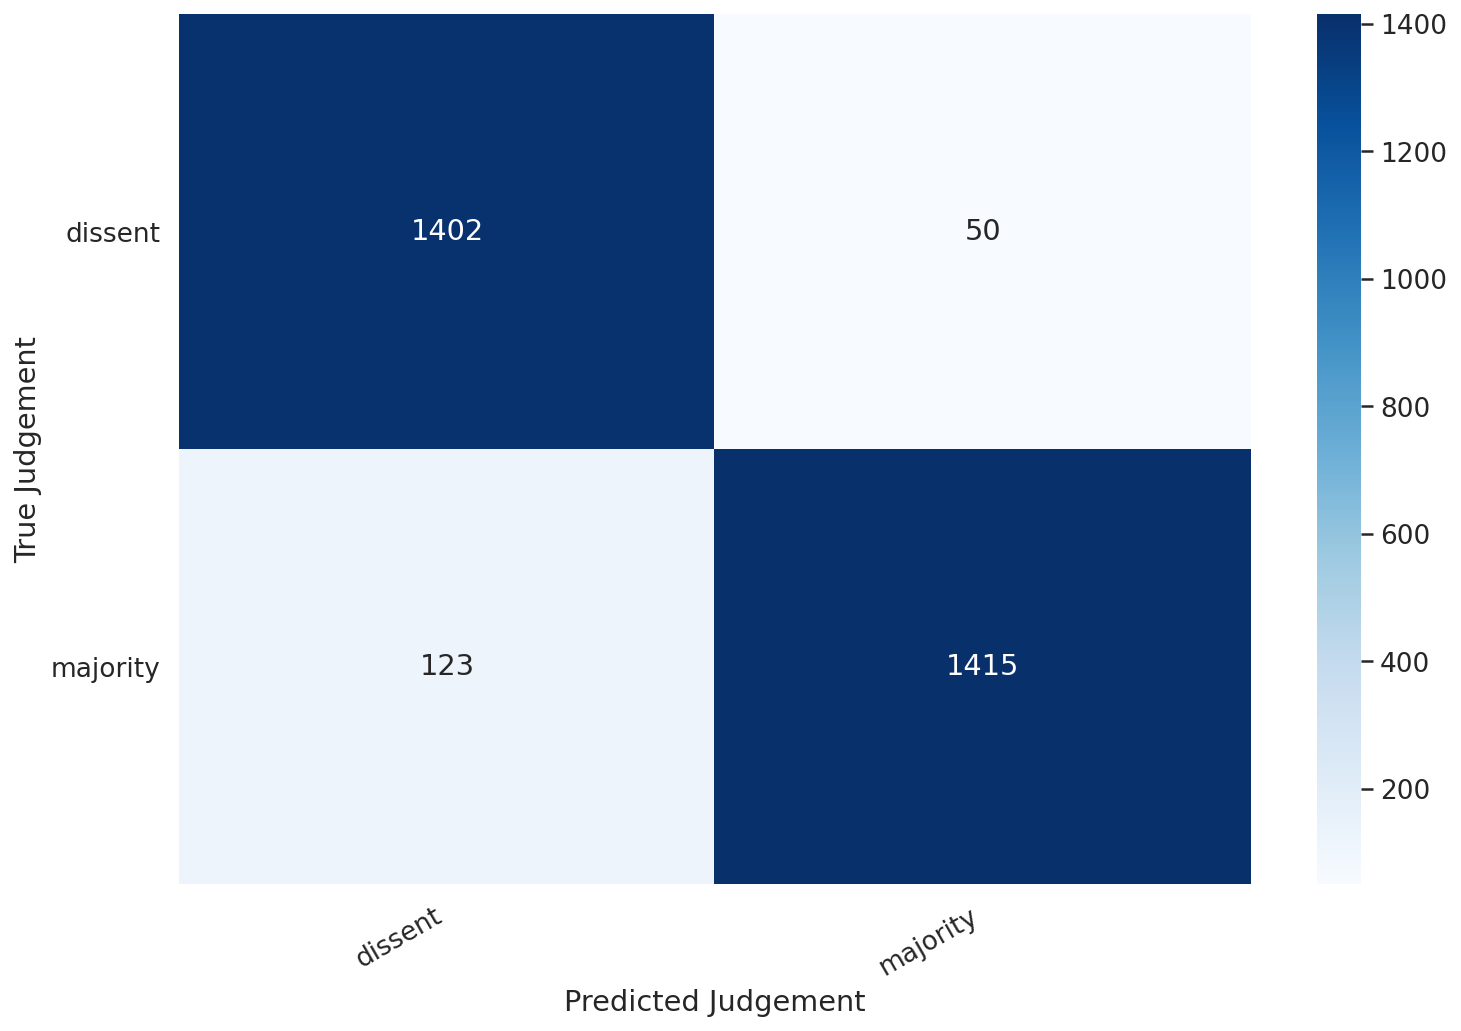

In [51]:
#Draw the confusion matrix
print(model_epoch)
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Judgement')
  plt.xlabel('Predicted Judgement');

cm = confusion_matrix(y_true=y_true, y_pred=y_predict)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)